In [1]:
# load llava-med
# from visualizer import get_local
# get_local.activate()

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"

from PIL import Image
import seaborn as sns
import torch
import torch.nn.functional as F
import json
import copy
import numpy as np

import sys
sys.path.append("/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med")

from llava import LlavaLlamaForCausalLM
from llava.conversation import conv_templates
from llava.utils import disable_torch_init
from transformers import CLIPVisionModel, CLIPImageProcessor, StoppingCriteria
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

from PIL import Image
import random
import math

from utils import show_image_relevance

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytr

In [2]:
# load model
ROOT_PATH="/data/aofei"
model_name = f"{ROOT_PATH}/LLM/llava_med"
# lora weights
# dir="llava_med/lora/epoch6"
# dataset="Slake"
# peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"

model_name = os.path.expanduser(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = LlavaLlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, use_cache=True).cuda()
# print("vision tower", model.config.mm_vision_tower)
image_processor = CLIPImageProcessor.from_pretrained(model.config.mm_vision_tower, torch_dtype=torch.float16)
vision_tower = model.model.vision_tower[0]
vision_tower.to(device='cuda', dtype=torch.float16)

mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
if mm_use_im_start_end:
    tokenizer.add_tokens([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)

vision_config = vision_tower.config
vision_config.im_patch_token = tokenizer.convert_tokens_to_ids([DEFAULT_IMAGE_PATCH_TOKEN])[0]
vision_config.use_im_start_end = mm_use_im_start_end
if mm_use_im_start_end:
    vision_config.im_start_token, vision_config.im_end_token = tokenizer.convert_tokens_to_ids([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN])
image_token_len = (vision_config.image_size // vision_config.patch_size) ** 2
print(image_token_len, "token length")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

256 token length


In [3]:
import clip
_, preprocess = clip.load("ViT-B/32", device='cpu', jit=False)

class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords, tokenizer, input_ids):
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.start_len = None
        self.input_ids = input_ids
        

    def __call__(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if self.start_len is None:
            self.start_len = self.input_ids.shape[1]
        else:
            
            outputs = self.tokenizer.batch_decode(output_ids[:, self.start_len:], skip_special_tokens=True)[0]
            for keyword in self.keywords:
                if keyword in outputs:
                    return True
        return False

In [4]:
def get_attention_weights_example(model, question, image_path, conv_mode="simple"):
    qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
    
    image = Image.open(image_path)
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
    images = image_tensor.unsqueeze(0).half().cuda()
    if getattr(model.config, 'mm_use_im_start_end', False):
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + DEFAULT_IM_END_TOKEN + '\n' +  qs
    else:
        qs = DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + '\n' + qs
    cur_prompt = '<image>' + '\n' +  qs

    conv = conv_templates[conv_mode].copy()
    conv.messages = []
    conv.append_message(conv.roles[0], qs)
    prompt = conv.get_prompt()
    inputs = tokenizer([prompt])

    input_ids = torch.as_tensor(inputs.input_ids).cuda()


    keywords = ['###']
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    

    with torch.inference_mode():
        outputs = model.generate(
            input_ids,
            images=images,
            do_sample=False,
            temperature=0.7,
            max_new_tokens=1024,
            output_attentions=False,
            output_hidden_states=True,
            return_dict_in_generate=True,
            stopping_criteria=[stopping_criteria])

    text = tokenizer.decode(outputs["sequences"][0]).strip()
    # cache = get_local.cache
    print(text.split("###")[-2])
    return text, outputs, input_ids, image

In [5]:
question = "What is the abnormity on the lungs in this image?"
# question = "Describe this image in details."
image_path = "./images/example2.jpg"
text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: The chest X-ray image shows a left-sided pleural effusion, which is an abnormal accumulation of fluid in the pleural space surrounding the lung.



In [7]:
outputs.keys()
hidden_states = outputs['hidden_states']

In [10]:
len(outputs['hidden_states']), len(outputs['hidden_states'][0]), outputs['hidden_states'][0][-1].size()

(42, 33, torch.Size([1, 313, 4096]))

In [12]:
import torch
import umap
import matplotlib.pyplot as plt


In [19]:
image_before_proj = torch.load("visual_embeddings/img_before_proj.pt").squeeze(0).detach().cpu().numpy()
image_after_proj = torch.load("visual_embeddings/img_after_proj.pt").squeeze(0).detach().cpu().numpy()

In [20]:
image_before_proj.shape

(256, 1024)

/tmp/ipykernel_1810596/395629105.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)


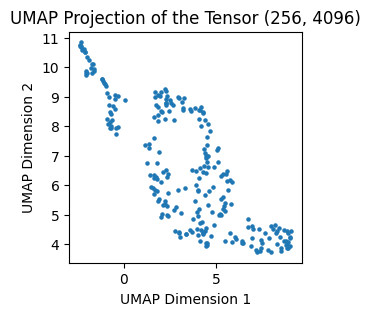

In [22]:
reducer = umap.UMAP(n_components=2)  # Reduce to 2 dimensions for 2D visualization
embedding = reducer.fit_transform(image_before_proj)
plt.figure(figsize=(3,3))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.title('UMAP Projection of the Tensor (256, 4096)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

/tmp/ipykernel_1810596/3302367116.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)


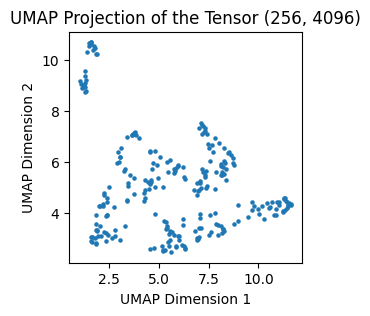

In [23]:
reducer = umap.UMAP(n_components=2)  # Reduce to 2 dimensions for 2D visualization
embedding = reducer.fit_transform(image_after_proj)
plt.figure(figsize=(3, 3))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.title('UMAP Projection of the Tensor (256, 4096)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

/tmp/ipykernel_1810596/3567082147.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)


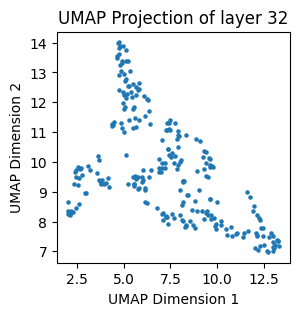

In [29]:
hidden_layer = outputs['hidden_states'][0][-1][:, 39:39+256].squeeze(0).detach().cpu().numpy()
embedding = reducer.fit_transform(hidden_layer)
plt.figure(figsize=(3, 3))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.title('UMAP Projection of layer 32')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()